**`COPYRIGHT(C) 2021 THE CYBER UNIVERSITY OF KOREA ALL RIGHTS RESERVED.`**

본 파일의 외부 배포를 금지합니다.

# 2번과제 - Latent 공간에서의 Smiling 벡터 적용하기 (33점)

**템플릿**

Computing MD5: vae_weights.tar.gz
MD5 matches: vae_weights.tar.gz
weights/
weights/keras_metadata.pb
weights/checkpoint.data-00000-of-00001
weights/checkpoint.index
weights/variables/
weights/variables/variables.data-00000-of-00001
weights/variables/variables.index
weights/saved_model.pb
weights/checkpoint
weights/assets/


2021-12-14 17:07:10.507465: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-14 17:07:10.955919: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-14 17:07:10.955956: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21493 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:b5:00.0, compute capability: 8.6
2021-12-14 17:07:11.435947: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-14 17:07:12.

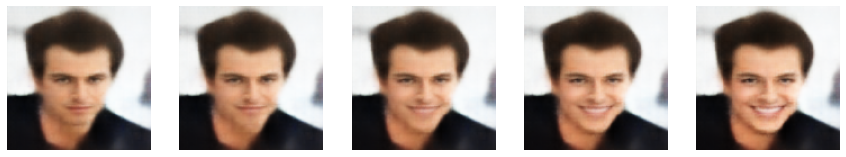

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import os
from glob import glob
import gdown
import matplotlib.pyplot as plt

# image_file, z_start, z_end 값을 `12_deepfake.ipynb`실습 실행 부분에서 복사하여 업데이트 합니다.
image_file = '008629.jpg'
z_start = np.array([ 0.51165247  , -1.1973262   , -0.18806714  ,  0.3593927   ,
       -0.9896692   ,  0.045576066 , -2.888544    ,  1.4802008   ,
       -0.2041829   , -1.1171055   ,  0.5371562   ,  0.42627877  ,
       -1.2309686   , -2.0550058   , -0.7537902   , -0.07680813  ,
        2.0452733   , -1.1311386   , -0.46550226  ,  1.5755489   ,
        0.58928674  ,  1.1791966   ,  0.94917655  ,  0.5987749   ,
        0.5815001   ,  0.28586265  ,  0.06696689  ,  0.9477665   ,
        1.8414605   ,  1.9119034   ,  1.0567036   ,  0.3615513   ,
       -0.4104105   , -0.59189254  ,  1.2174647   ,  0.9946472   ,
        0.5241927   ,  2.1389232   , -0.51414186  , -0.7504797   ,
       -0.19267002  ,  1.0049567   ,  0.006421149 ,  0.82332313  ,
       -1.2039635   ,  0.4026336   ,  0.59752977  , -0.6505483   ,
       -0.14467421  , -1.1081607   , -1.0387355   ,  0.22033802  ,
        1.2906396   , -0.7465883   , -1.3119192   ,  1.8650314   ,
        0.7424985   ,  0.11610429  ,  0.53767824  ,  0.53099585  ,
       -0.062205195 , -0.43539634  , -0.49824527  ,  2.2648535   ,
        2.1154332   , -1.6803362   , -0.3174094   , -1.7905765   ,
        0.9095981   , -0.9161087   , -1.2652929   ,  1.1605979   ,
        1.5348216   ,  0.41232628  ,  0.008829355 ,  0.9567587   ,
       -0.8195963   , -2.156269    , -2.6899538   ,  0.89053595  ,
        0.83673096  , -1.840965    , -0.633362    ,  1.0299332   ,
       -1.9534174   , -0.85963917  , -0.20637904  ,  2.2067776   ,
       -0.21448427  ,  0.7314191   ,  1.7930303   ,  0.4430193   ,
       -0.7764752   ,  0.22775775  , -3.3790393   , -1.9394097   ,
       -1.1407137   ,  0.48087054  ,  1.0355675   ,  2.1436706   ,
        0.0357095   ,  0.47831464  , -0.17529714  ,  1.6886916   ,
       -0.60205996  , -2.149939    , -0.0059643984, -1.1478593   ,
        0.54694295  ,  2.3754637   , -0.31710178  ,  0.5101158   ,
        3.7773082   , -2.9317229   ,  1.9140741   ,  2.9450448   ,
        1.1843758   , -0.42405456  ,  1.2523038   ,  1.0985551   ,
       -1.1079183   , -0.9630812   , -0.18411824  ,  1.7597651   ,
        1.8354247   , -1.2998254   ,  1.515741    , -0.42342514  ,
        0.24223435  , -0.018041998 , -0.6703321   , -0.25324938  ,
       -1.5229226   , -0.82424057  ,  1.5374343   ,  0.9183435   ,
        0.77907187  , -0.6780119   ,  0.5217359   ,  0.38324603  ,
        1.038603    ,  0.79478425  ,  0.4412514   , -0.7481872   ,
        0.07701512  , -0.36489725  , -0.057156853 ,  0.3818175   ,
       -0.38217247  , -1.7098536   , -1.6881626   ,  0.99543333  ,
        1.6156795   , -0.24023664  , -0.7471294   ,  0.4793784   ,
        0.24937457  ,  0.12624429  , -1.4913517   , -0.73625934  ,
        0.5789245   , -0.5684443   , -0.72188705  ,  0.12764175  ,
       -2.6191442   ,  0.700166    ,  0.39041132  ,  0.08008385  ,
       -0.37719724  , -1.0280637   ,  0.21381554  ,  0.07182546  ,
        1.173063    ,  0.23851879  , -1.134413    ,  0.628986    ,
       -1.6083932   , -0.7461231   ,  0.13498461  ,  0.32760397  ,
        0.8181643   , -2.3889465   , -0.030497007 , -0.07983138  ,
        0.5969469   ,  0.61000985  ,  1.461432    , -0.3340329   ,
        1.7357419   ,  0.49665862  ,  0.47224945  ,  0.75099295  ,
        2.3244333   ,  0.3104105   ,  1.5840006   , -0.053501666 ,
       -1.2293062   , -1.2836668   ,  3.0475667   ,  0.2972155   ],
      dtype='float32')
z_end = np.array([ 5.72977960e-01, -1.17467523e+00, -1.95226938e-01,  2.44418800e-01,
       -1.07260275e+00, -3.16603482e-02, -3.04139423e+00,  1.54305375e+00,
       -1.64888859e-01, -8.53234768e-01,  4.66521442e-01,  3.83821785e-01,
       -1.43313909e+00, -1.87543082e+00, -4.99349624e-01, -1.70870394e-01,
        1.77098560e+00, -1.21392393e+00, -4.80084658e-01,  1.64434516e+00,
        1.88662839e+00,  1.13736928e+00, -1.17789865e-01,  5.08254766e-01,
        5.75029373e-01,  3.71077269e-01,  1.09070159e-01,  1.00230491e+00,
        1.69477463e+00,  1.94024813e+00,  1.07472181e+00,  2.08851844e-01,
       -4.09724802e-01, -5.65167069e-01,  1.23436999e+00,  4.20415044e-01,
        4.03792560e-01,  2.17169404e+00, -5.13979256e-01, -7.00644433e-01,
       -4.12017405e-01,  9.01915193e-01,  4.75870430e-01,  8.44886363e-01,
       -1.25241423e+00,  4.50602233e-01,  6.26643658e-01, -6.78528130e-01,
       -5.26039004e-01, -7.46038795e-01, -7.62022972e-01,  2.15544313e-01,
        3.76785815e-01, -5.60305238e-01, -1.29251766e+00,  1.88069797e+00,
        6.80058718e-01, -7.69171864e-03,  5.51092267e-01,  5.25287628e-01,
       -1.20652840e-03, -4.22662735e-01, -3.14550579e-01,  2.87449431e+00,
        1.78322077e+00, -2.02736044e+00, -2.50060737e-01, -1.69495666e+00,
        8.50703776e-01, -8.20137918e-01, -1.39862287e+00,  1.12130570e+00,
        1.63355219e+00,  1.56464845e-01,  2.28159390e-02,  1.48026490e+00,
       -7.36107945e-01, -2.69309950e+00, -2.67915940e+00,  9.00430441e-01,
        8.59273136e-01, -1.87040365e+00, -5.33185482e-01,  9.74141240e-01,
       -2.00012422e+00, -8.29578996e-01, -4.01541889e-01,  2.28007412e+00,
       -2.36341104e-01,  6.12758756e-01,  1.82076514e+00,  5.61124325e-01,
       -8.30627978e-01,  3.54324281e-01, -2.40655708e+00, -1.78879988e+00,
       -1.16929054e+00,  4.51794624e-01,  4.65384901e-01,  2.12182879e+00,
        3.66598874e-01,  2.29912758e-01, -3.13030750e-01,  1.51989603e+00,
       -3.05434644e-01, -2.09333229e+00, -2.84276865e-02, -1.11931121e+00,
        4.25237447e-01,  2.52315187e+00, -2.79049665e-01,  3.10506999e-01,
        3.65646696e+00, -2.84021711e+00,  1.77909219e+00,  2.54825330e+00,
        1.07033658e+00,  1.03108704e-01,  1.32091248e+00,  1.03996384e+00,
       -2.13494015e+00, -8.67035031e-01, -1.26776934e-01,  1.75396907e+00,
        1.07416964e+00, -1.34220207e+00,  1.65193868e+00, -4.75422591e-01,
        1.55517697e-01, -1.14617862e-01, -6.67772591e-01, -3.13118905e-01,
       -1.39692926e+00, -8.44218612e-01,  2.50200295e+00,  9.17499244e-01,
        7.17299461e-01, -1.70274711e+00,  6.24216914e-01,  4.03311908e-01,
        6.48391664e-01,  8.70243251e-01,  4.31221575e-01,  2.20583677e-02,
        1.71008140e-01, -3.80540580e-01, -1.39102489e-01,  3.67843717e-01,
       -7.73660719e-01, -1.74468589e+00, -1.73297906e+00,  1.03721666e+00,
        1.66422296e+00, -7.99888730e-01, -1.00115657e+00,  4.83160436e-01,
        2.40218386e-01,  3.61453891e-02, -1.24380159e+00, -1.15480435e+00,
        6.45831466e-01, -3.64400446e-01, -6.47031784e-01,  3.84977460e-02,
       -2.63333535e+00,  5.28283715e-01,  3.88369769e-01,  7.97789097e-02,
       -4.78187680e-01, -9.69784558e-01,  1.41845986e-01,  1.58796579e-01,
        1.13848770e+00,  2.02747107e-01, -8.36311102e-01,  5.71853220e-01,
       -1.48306406e+00, -6.87719882e-01, -1.65692091e-01,  2.45054603e-01,
        7.54548907e-01, -3.58206987e+00, -9.21691954e-02,  1.52216822e-01,
        5.73537290e-01,  6.43846810e-01,  1.43375707e+00, -3.37227434e-01,
        1.85679078e+00,  4.50727373e-01,  4.55063194e-01,  8.84635687e-01,
        2.12412310e+00,  4.25927699e-01,  1.81570625e+00, -6.59308583e-02,
       -1.15431726e+00, -1.32918453e+00,  2.89771724e+00,  2.50184685e-01],
      dtype='float32')


INPUT_DIM = (128,128,3)
BATCH_SIZE = 32

md5 = 'b387a8f59bd8bc09ee1eb12a80294379'  
url = 'https://drive.google.com/uc?id=19m6cQVNqXRhD6iEGkjA8ZZcOdev_b2V1'
output = 'vae_weights.tar.gz'

gdown.cached_download(url, output, md5=md5)

!mkdir -p vae_data
!tar xvzf vae_weights.tar.gz -C vae_data

class Sampling(layers.Layer):
    """Uses (mu, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mu, log_var = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(log_var/2) * epsilon

z_dim = 200
r_loss_factor = 10000

encoder_input = keras.Input(shape=INPUT_DIM, name='encoder_input')
x = Conv2D(32, 3, strides=2, padding="same", name='encoder_conv_0')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_1')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_3')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
mu = Dense(z_dim, name='mu')(x)
log_var = Dense(z_dim, name='log_var')(x)
z = Sampling(name='encoder_output')([mu, log_var])
encoder = keras.Model(encoder_input, [mu, log_var, z], name = 'encoder')

decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t0')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t1')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", name='decoder_conv_t2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(3, 3, strides=2, padding="same", name='decoder_conv_t3')(x)
decoder_output = Activation('sigmoid')(x)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")

class VAEModel(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= r_loss_factor
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": tf.reduce_mean(total_loss),
            "reconstruction_loss": tf.reduce_mean(reconstruction_loss),
            "kl_loss": tf.reduce_mean(kl_loss),
        }

    def call(self,inputs):
        _,_,latent = self.encoder(inputs)
        return self.decoder(latent)

VAE = VAEModel(encoder, decoder)
LEARNING_RATE = 0.0005
VAE.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

SAVE_FOLDER = 'vae_data'
save_folder = os.path.join(SAVE_FOLDER, 'weights')
VAE.load_weights(save_folder+'/'+'checkpoint')

smiling_vec = (z_end - z_start)/4
factors = [0,1,2,3,4]
fig = plt.figure(figsize=(18, 10))
for counter, factor in enumerate(factors):
    changed_z_point = z_start + smiling_vec * factor
    changed_image = VAE.decoder.predict(np.array([changed_z_point]))[0]
    img = changed_image.squeeze()
    sub = fig.add_subplot(1, len(factors) + 1, 1+counter)
    sub.axis('off')
    sub.imshow(img)
    


#  z텐서의 배열 내에 `attribute==1` 혹은 `attribute==-1`라는 boolean tensor를 입력하였습니다.  
#  텐서의 배열에 boolean tensor를 넣으면 역할을 하는지 각자 공부해 보고 그 역할에 대해 `ans06`에 기입합니다. 
ans06 = """
여기에 기입하세요.
"""

# `np.sum(z_POS, axis = 0)` 합계를 할 때에 `axis=0`을 주었습니다.
#  그 이유에 대해 생각해보고 `ans07`에 기입합니다.  
ans07 = """
여기에 기입하세요.
"""

#  `if np.sum([movement_POS, movement_NEG]) < 0.08:` 이 조건을 만족시키면 평균 계산 루프가 중단되도록 되어 있습니다.  
#  이 조건은 어떤 의미인지 `ans08`에 기입합니다. 
ans08 = """
여기에 기입하세요.
"""

ans09 = image_file
ans10 = z_start.copy()
ans11 = z_end.copy()

In [125]:
!rm report3/z_end.npy
npy_list = sorted(glob('report3/*.npy'), key=os.path.getmtime, reverse=True)

imgs = np.empty((75,200), dtype='float32')
for i, npy_file in enumerate(npy_list):
    if (i==len(imgs)):
        break
    print(i, npy_file)
    z = np.load(npy_file)
    imgs[i] = z

np.save('z_smiling.npy', imgs)

rm: 'report3/z_end.npy'를 지울 수 없음: 그런 파일이나 디렉터리가 없습니다
0 report3/김진영_zero140520_202032146.npy
1 report3/김효영_legbigi88_202131671.npy
2 report3/허인회_hih0418_202031861.npy
3 report3/허성철_hsc6685_202032578.npy
4 report3/한성용_bitpsec1_202031847.npy
5 report3/표민경_pyomk0620_202132398.npy
6 report3/최우식_monatory20_202030435.npy
7 report3/조혜인_heyin416_202032445.npy
8 report3/조형제_joje0327_202130490.npy
9 report3/장순웅_evfr31_202030766.npy
10 report3/장만식_mansiggi01_202032496(기말).npy
11 report3/장경환_nightholicmp1_202132571.npy
12 report3/임철홍_imich0904_14_final_report_201711412.npy
13 report3/임수환_gojila1029_202020199.npy
14 report3/이현정_hjlee0320_202032048 (3).npy
15 report3/이진규_ljg1859_202010843.npy
16 report3/이지환_rabbitking1_202010779.npy
17 report3/이지혜_jihyelee899_202030616.npy
18 report3/이정은_anna6018_202011016.npy
19 report3/이재성_syama70_202132155.npy
20 report3/이재권_firelee74_202131680.npy
21 report3/이의정_euijung0301_202032553.npy
22 report3/이아성_mission21_201930738.npy
23 report3/이승훈_cuksky21_202131795.npy

In [138]:
!zip -o z_smiling.zip z_smiling.npy

  adding: z_smiling.npy (deflated 8%)


In [136]:
z_data = np.load('z_smiling.npy')
images = VAE.decoder.predict(z_data)
print(z_data.shape)

(75, 200)


In [135]:
# check distance
n = z_data.shape[0]
min_dist = 999.
for i in range(n):
    z1 = z_data[i]
    for j in range(i+1, n):
        z2 = z_data[j]
        dist = np.sqrt(np.sum((z1-z2)**2))
        if (dist < min_dist):
            min_dist = dist
            print(i, j, dist)

0 1 17.627228
0 6 16.803053
1 15 16.722963
1 29 16.539907
1 36 16.148092
4 42 15.465507
24 42 15.264301


In [130]:
import matplotlib.font_manager as fm
import matplotlib
fm.get_fontconfig_fonts()
font_location = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'
#font_location = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
fprop = fm.FontProperties(fname=font_location)

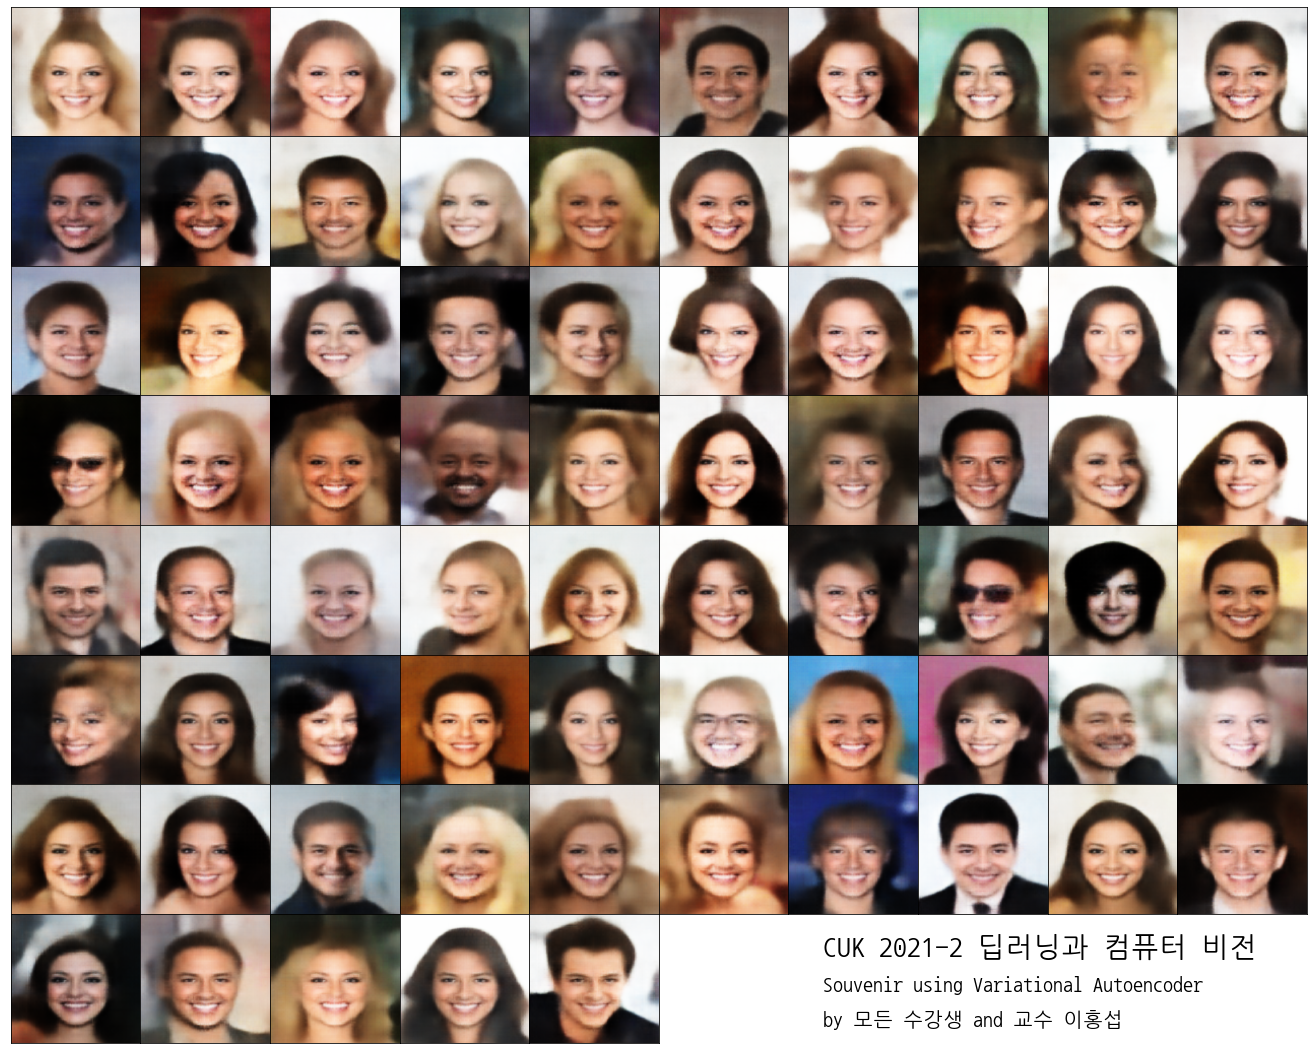

In [131]:
n_col = 10
n_row = (len(npy_list)+n_col-1)//n_col
fig = plt.figure(figsize=(18,20), facecolor='white')
for i in range(75):
    #sub = fig.add_subplot(n_row, n_col, 1+i, gridspec_kw={'wspace':0, 'hspace':0},
    #                       squeeze=True)
    sub = fig.add_subplot(n_row, n_col, 1+i)
    #sub.axis('off')
    sub.set_yticklabels([])
    sub.set_xticklabels([])
    sub.set_xticks([])
    sub.set_yticks([])
    sub.set_xticks([], minor=True)
    sub.set_yticks([], minor=True)
    sub.imshow(images[i], aspect='equal')
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=0.99)
plt.text(290, 40, "CUK 2021-2 딥러닝과 컴퓨터 비전", color='black', fontproperties=fprop, fontsize=28)
plt.text(290, 75, "Souvenir using Variational Autoencoder", color='black', fontproperties=fprop, fontsize=20)
plt.text(290, 110, "by 모든 수강생 and 교수 이홍섭", color='black', fontproperties=fprop, fontsize=20)
#plt.tight_layout()
plt.show()

report3/김진영_zero140520_202032146.npy
report3/김효영_legbigi88_202131671.npy
report3/z_end.npy
report3/허인회_hih0418_202031861.npy
report3/허성철_hsc6685_202032578.npy
report3/한성용_bitpsec1_202031847.npy
report3/표민경_pyomk0620_202132398.npy
report3/최우식_monatory20_202030435.npy
report3/조혜인_heyin416_202032445.npy
report3/조형제_joje0327_202130490.npy
report3/장순웅_evfr31_202030766.npy
report3/장만식_mansiggi01_202032496(기말).npy
report3/장경환_nightholicmp1_202132571.npy
report3/임철홍_imich0904_14_final_report_201711412.npy
report3/임수환_gojila1029_202020199.npy
report3/이현정_hjlee0320_202032048 (3).npy
report3/이진규_ljg1859_202010843.npy
report3/이지환_rabbitking1_202010779.npy
report3/이지혜_jihyelee899_202030616.npy
report3/이정은_anna6018_202011016.npy
report3/이재성_syama70_202132155.npy
report3/이재권_firelee74_202131680.npy
report3/이의정_euijung0301_202032553.npy
report3/이아성_mission21_201930738.npy
report3/이승훈_cuksky21_202131795.npy
report3/이미순_misoonlee04_202131733.npy
report3/이도경_ldk930424_202131182_이도경 (4).npy
report3/이기성_ai

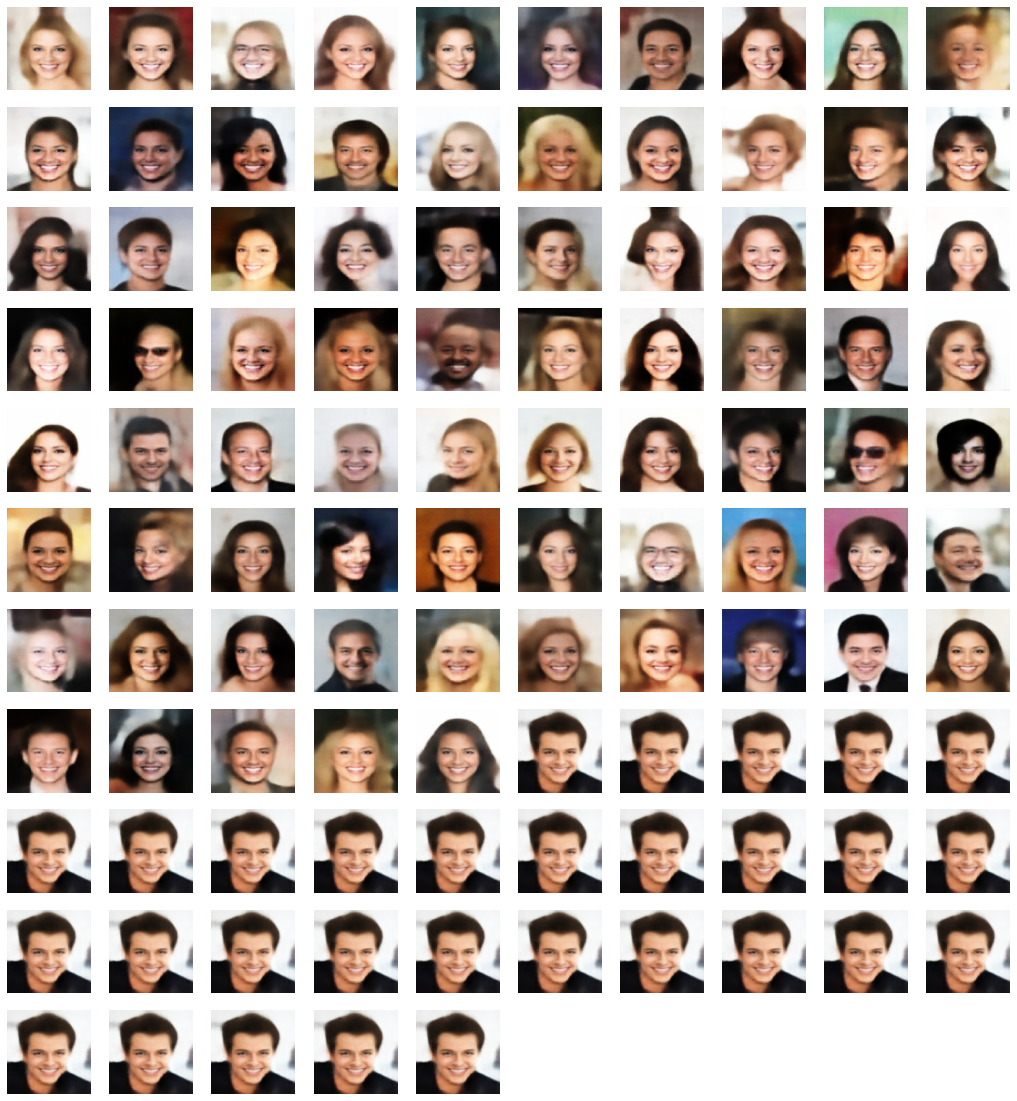

In [14]:
npy_list = sorted(glob('report3/*.npy'), key=os.path.getmtime, reverse=True)

n_col = 10
n_row = (len(npy_list)+n_col-1)//n_col
fig = plt.figure(figsize=(18,20))
for i, npy_file in enumerate(npy_list):
    print(npy_file)
    z = np.load(npy_file)
    img = VAE.decoder.predict(np.array([z]))[0]
    sub = fig.add_subplot(n_row, n_col, 1+i)
    sub.axis('off')
    sub.imshow(img)
plt.show()
